In [29]:
import pandas as pd
import numpy as np
!pip install scanpy
import scanpy as sc
import requests
import json
import os, sys

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
sys.path.append("/content/drive/My Drive/phd/hsbm-occam")

# Download data

In [0]:
#path/to/files/downloaded/from 
#https://doi.org/10.6084/m9.figshare.5330593
#https://figshare.com/articles/Data_record_2/5330575
working_dir = "/content/drive/My Drive/phd/datasets/merged/"
os.chdir(working_dir)

In [0]:
files = filter(lambda f: "fpkm" in f, os.listdir("data"))

In [0]:
df_gtex=pd.read_csv("https://storage.googleapis.com/gtex_analysis_v8/annotations/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt", sep='\t', index_col=0)

In [0]:
filters = {
    "op": "and",
    "content":[
        {
        "op": "in",
        "content":{
            "field": "cases.project.program.name",
            "value": ["TCGA"]
            }
        }
        
    ]
}
params = {
    "filters": json.dumps(filters),
    "fields": "primary_site,disease_type,submitter_id",
    "format": "TSV",
    "size": "10000000"
    }
response = requests.get("https://api.gdc.cancer.gov/cases", headers = {"Content-Type": "application/json"}, params = params)
with open("files.txt","w") as file:
    file.write(response.content.decode("utf-8"))
    file.close()
df_tcga = pd.read_csv("files.txt", sep='\t').set_index("submitter_id")

In [0]:
df=pd.DataFrame()

In [0]:
for i,file in enumerate(files):
  df = df.append(pd.read_csv("data/%s"%file, sep='\t', index_col=0).drop('Entrez_Gene_Id',1).transpose(), sort=True)
df = df.transpose()
df = df.dropna(how='any', axis=0) # drop genes not always determined

0


In [0]:
df = pd.read_csv("mainTable_all.csv", index_col=0)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18154 entries, A1BG to hsa-mir-1199
Columns: 9147 entries, TCGA-E8-A2JQ-11A-11R-A180-07 to TCGA-AA-3534-11A-01R-A32Z-07
dtypes: float64(9147)
memory usage: 1.2+ GB


In [0]:
df_files = pd.DataFrame(index=df.columns)

In [0]:
def get_site(file):
    if 'GTEX' in file:
        return df_gtex.at[file, 'SMTS']
    if 'TCGA' in file:
        return df_tcga.at[file[:12],'primary_site']

def get_source(file):
    if 'GTEX' in file:
        return 'gtex'
    if 'TCGA' in file:
        return 'tcga'

def get_status(file):
  if 'GTEX' in file:
        return 'healthy'
  if 'TCGA' in file:
      if (file[13:15]=="11") or (file[13:15]=="10"):
        return 'healthy'
      else:
        return "tumor"

In [0]:
df_files.insert(0, 'primary_site', [get_site(file) for file in df.columns])
df_files.insert(1, 'dataset', [get_source(file) for file in df.columns])
df_files.insert(1, 'status', [get_status(file) for file in df.columns])
df_files.groupby(["dataset","status"]).count()

primary_site
dataset status               
gtex    healthy          2322
tcga    healthy           683
        tumor            6142

In [0]:
#df.to_csv("mainTable_all.csv", index=True, header=True)
df_files.to_csv("files.dat", index=True, header=True)

## Split / shuffle and select

In [0]:
df_files.replace('Uterus, NOS', 'Uterus', inplace=True)
df_files.replace('Bronchus and lung', 'Lung', inplace=True)
df_files.replace('Liver and intrahepatic bile ducts', 'Liver', inplace=True)
df_files.replace('Prostate gland', 'Prostate', inplace=True)
df_files.replace('Thyroid gland', 'Thyroid', inplace=True)
df_files.replace('Base of Tongue', 'Salivary Gland', inplace=True)
df_files.replace('Bones, joints and articular cartilage of other and unspecified sites', 'Salivary Gland', inplace=True)
df_files.replace('Floor of mouth', 'Salivary Gland', inplace=True)
df_files.replace('Gum', 'Salivary Gland', inplace=True)
df_files.replace('Hypopharynx', 'Salivary Gland', inplace=True)
df_files.replace('Larynx', 'Salivary Gland', inplace=True)
df_files.replace('Lip', 'Salivary Gland', inplace=True)
df_files.replace('Oropharynx', 'Salivary Gland', inplace=True)
df_files.replace('Other and ill-defined sites in lip, oral cavity and pharynx', 'Salivary Gland', inplace=True)
df_files.replace('Other and unspecified parts of mouth', 'Salivary Gland', inplace=True)
df_files["tissue_hd"]=df_files["primary_site"]+"_"+df_files["status"]
df_files['primary_site'].unique()

array(['Thyroid', 'Prostate', 'Rectosigmoid junction', 'Rectum',
       'Connective, subcutaneous and other soft tissues', 'Colon',
       'Esophagus', 'Salivary Gland',
       'Other and unspecified parts of tongue', 'Base of tongue',
       'Kidney', 'Liver', 'Gallbladder',
       'Other and unspecified parts of biliary tract', 'Lung',
       'Corpus uteri', 'Stomach', 'Breast', 'Uterus', 'Cervix Uteri',
       'Bladder', 'Cervix uteri', 'Tonsil', 'Palate'], dtype=object)

In [0]:
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5903355/
sites_with_enough_statistics = ['Breast', 'Colon', 'Liver', 'Esophagus', 'Prostate', 'Stomach', 'Lung', 'Uterus']

In [0]:
rs = np.random.RandomState(seed=42)
samples = pd.DataFrame(columns=df_files.columns)
for site in sites_with_enough_statistics:
    samples = samples.append(df_files[(df_files['primary_site']==site) & (df_files['dataset']=='tcga')].sample(50, random_state=rs))
    samples = samples.append(df_files[(df_files['primary_site']==site) & (df_files['dataset']=='gtex')].sample(50, random_state=rs))

In [0]:
samples.groupby('primary_site').count()

,dataset,tissue_hd
primary_site,,
Breast,100,100
Colon,100,100
Esophagus,100,100
Liver,100,100
Lung,100,100
Prostate,100,100
Stomach,100,100
Uterus,100,100


In [0]:
samples.groupby('dataset').count()

,primary_site,tissue_hd
dataset,,
gtex,400,400
tcga,400,400


In [0]:
df[df.columns[~df.columns.isin(samples.index) & df.columns.isin(df_files[df_files["primary_site"].isin(sites_with_enough_statistics)].index)]].to_csv("mainTable_test.csv", index=True, header=True)

In [0]:
df[df.columns[df.columns.isin(samples.index)]].to_csv("mainTable_train.csv", index=True, header=True)

In [0]:
df_files["tissue_hd"].unique()

array(['Thyroid_healthy', 'Prostate_tumor', 'Rectosigmoid junction_tumor',
       'Rectum_tumor',
       'Connective, subcutaneous and other soft tissues_tumor',
       'Colon_tumor', 'Esophagus_healthy', 'Salivary Gland_healthy',
       'Other and unspecified parts of tongue_healthy',
       'Base of tongue_healthy', 'Kidney_healthy', 'Liver_tumor',
       'Gallbladder_tumor',
       'Other and unspecified parts of biliary tract_tumor',
       'Lung_healthy', 'Liver_healthy', 'Corpus uteri_tumor',
       'Esophagus_tumor', 'Stomach_tumor', 'Breast_healthy',
       'Uterus_healthy', 'Corpus uteri_healthy',
       'Other and unspecified parts of biliary tract_healthy',
       'Cervix Uteri_healthy', 'Bladder_tumor', 'Bladder_healthy',
       'Stomach_healthy', 'Cervix uteri_tumor', 'Cervix uteri_healthy',
       'Kidney_tumor', 'Lung_tumor', 'Prostate_healthy',
       'Salivary Gland_tumor',
       'Other and unspecified parts of tongue_tumor',
       'Base of tongue_tumor', 'Tonsil_tum

In [0]:
df_files["tissue_hd"]=df_files["primary_site"]+"_"+df_files["status"]

In [0]:
df_files.to_csv("files.dat", index=True, header=True)

# Load Data

In [30]:
df = pd.read_csv("mainTable_all.csv", index_col=0)
df_files = pd.read_csv("files.dat", index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18154 entries, A1BG to hsa-mir-1199
Columns: 9147 entries, TCGA-E8-A2JQ-11A-11R-A180-07 to TCGA-AA-3534-11A-01R-A32Z-07
dtypes: float64(9147)
memory usage: 1.2+ GB


In [0]:
samples = df_files[df_files["primary_site"]=="Lung"]

In [0]:
df[samples.index].to_csv("mainTable_lung.csv")

# Use scanpy to filter HVG

In [0]:
adata = sc.AnnData(df[samples.index].transpose(), obs=samples)
adata_log = sc.pp.log1p(adata, copy=True)

In [0]:
sc.pp.highly_variable_genes(adata_log, n_top_genes=3000, n_bins=50)

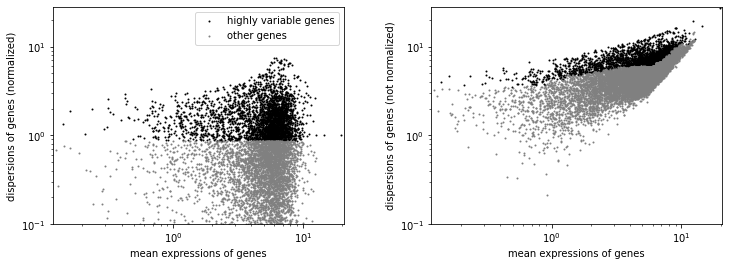

In [35]:
sc.pl.highly_variable_genes(adata_log, log=True, save='hvg_lung.pdf')

In [0]:
hvg = adata_log.var[adata_log.var['highly_variable']==True].index
samples = adata_log.obs.index

In [0]:
df.reindex(index=hvg, columns=samples).to_csv("mainTable_lung.csv")

# Use SBM

In [38]:
!echo "deb http://downloads.skewed.de/apt bionic main" >> /etc/apt/sources.list
!echo "deb-src http://downloads.skewed.de/apt/ bionic main" >> /etc/apt/sources.list
!apt-key adv --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
!apt-get update && apt-get install python3-graph-tool --yes

Executing: /tmp/apt-key-gpghome.Q88sxRXKNx/gpg.1.sh --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
gpg: key 612DEFB798507F25: "Tiago de Paula Peixoto <tiago@skewed.de>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
Hit:1 http://downloads.skewed.de/apt bionic InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:5 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net

In [39]:
from sbmtm import sbmtm

/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/all.py:40: RuntimeWarning: Error importing draw module, proceeding nevertheless: No module named 'cairo'
  warnings.warn(msg, RuntimeWarning)


In [0]:
model = sbmtm()

In [50]:
model.make_graph_from_BoW_df(df.reindex(index=hvg, columns=samples).astype(float).dropna(how="any", axis=0).applymap(lambda fpkm: np.log2(fpkm+1)))

In [0]:
model.save_graph("graph_lung.xml.gz")

In [52]:
config = "lung"
os.system(f"mkdir -p {config}")
os.chdir(f"{config}")
model.fit(n_init=1, parallel=True, verbose=True, B_min=5, B_max=200)
model.save_data()

TypeError: ignored